In [1]:
import numpy as np
import pandas as pd

from data_proccessing import get_historical_ohlc
from pybit.unified_trading import HTTP
from constants import API_KEY, API_SECRET

In [2]:
session = HTTP(demo=True, api_key=API_KEY, api_secret=API_SECRET)
ohlc_m15 = get_historical_ohlc(session=session, symbol='BTCUSDT', interval='15')
ohlc_m5 = get_historical_ohlc(session=session, symbol='BTCUSDT', interval='5')


In [3]:

ohlc_m15

,time,open,high,low,close,volume
0,2025-08-05 11:45:00,114893.3,114893.4,114711.0,114782.3,594.657
1,2025-08-05 12:00:00,114782.3,114860.0,114703.4,114860.0,178.923
2,2025-08-05 12:15:00,114860.0,114860.0,114315.9,114470.2,1276.840
3,2025-08-05 12:30:00,114470.2,114470.2,113424.2,113813.9,3472.536
4,2025-08-05 12:45:00,113813.9,114052.0,113806.0,113889.9,1040.928
...,...,...,...,...,...,...
4995,2025-09-26 12:30:00,109070.5,109555.0,108863.5,109466.0,2623.144
4996,2025-09-26 12:45:00,109466.0,109515.5,109126.5,109330.5,685.656
4997,2025-09-26 13:00:00,109330.5,109484.8,109099.9,109113.6,705.094
4998,2025-09-26 13:15:00,109113.6,109290.0,109034.1,109133.6,423.304


In [4]:
def detect_fvg(last_3_candels):

    fvg = 0
    fvg_top = 0
    fvg_bottom = 0

    high = last_3_candels['high'].values
    low = last_3_candels['low'].values

    if low[-1] > high[0]:

        fvg = 1
        fvg_top = low[-1]
        fvg_bottom = high[0]

    elif high[-1] < low[0]:
        
        fvg = -1
        fvg_top = low[0]
        fvg_bottom = high[-1]

    return fvg, fvg_top, fvg_bottom

In [5]:
from plotting import plotting_chart, plotting_chart_technicals

In [6]:
def detect_fractal(last_3_candels):
    
    fractal = 0
    fractal_level = 0

    high = last_3_candels['high'].values
    low = last_3_candels['low'].values

    if high[-2] > high[-1] and high[-2] > high[-3]:
        
        fractal += 1
        fractal_level = high[-2]

    if low[-2] < low[-1] and low[-2] < low[-3]:
            
            fractal -= 1
            fractal_level = low[-2]

    return fractal, fractal_level

In [7]:
all_fvg = [0, 0]
all_fvg_top = [0, 0]
all_fvg_bottom = [0, 0]
all_fractal = [0, 0]
all_fractal_levels = [0, 0]


for i in range(2, len(ohlc_m5)):

    last_3_candels_m5 = ohlc_m5.iloc[i-2:i+1]
    last_3_candels_m15 = ohlc_m15.iloc[i-2:i+1]
    fvg, fvg_top, fvg_bottom = detect_fvg(last_3_candels_m15)
    fractal, fractal_level = detect_fractal(last_3_candels_m5)
    all_fvg.append(fvg)
    all_fvg_top.append(fvg_top)
    all_fvg_bottom.append(fvg_bottom)
    all_fractal.append(fractal)
    all_fractal_levels.append(fractal_level)

all_fvg = pd.Series(all_fvg, name='fvg')
all_fvg_top = pd.Series(all_fvg_top, name='fvg_top')
all_fvg_bottom = pd.Series(all_fvg_bottom, name='fvg_bottom')
all_fractal = pd.Series(all_fractal, name='fractal')
all_fractal_levels = pd.Series(all_fractal_levels, name='fractal_levels')

ohlc = pd.concat([ohlc_m15, all_fvg, all_fvg_top, all_fvg_bottom, all_fractal, all_fractal_levels], axis=1)

In [8]:
def detect_bos(df):
    bos = [0, 0]
    bos_level = [np.nan, np.nan]
    bos_fractal_index = [np.nan, np.nan]
    bos_fractal_time = [pd.NaT, pd.NaT]

    last_high_fractal = np.nan
    last_high_idx = np.nan
    last_high_time = pd.NaT

    last_low_fractal = np.nan
    last_low_idx = np.nan
    last_low_time = pd.NaT

    for i in range(2, len(df)):
        prev = df.iloc[i - 1]

        if prev['fractal'] == 1:
            last_high_fractal = prev['fractal_levels']
            last_high_idx = i - 1
            last_high_time = prev['time']
        elif prev['fractal'] == -1:
            last_low_fractal = prev['fractal_levels']
            last_low_idx = i - 1
            last_low_time = prev['time']

        candle = df.iloc[i]
        body_high = max(candle['open'], candle['close'])
        body_low = min(candle['open'], candle['close'])

        signal = 0
        level = np.nan
        source_idx = np.nan
        source_time = pd.NaT

        if not np.isnan(last_high_fractal) and body_low > last_high_fractal:
            signal = 1
            level = last_high_fractal
            source_idx = last_high_idx
            source_time = last_high_time
            last_high_fractal = np.nan
            last_high_idx = np.nan
            last_high_time = pd.NaT

        elif not np.isnan(last_low_fractal) and body_high < last_low_fractal:
            signal = -1
            level = last_low_fractal
            source_idx = last_low_idx
            source_time = last_low_time
            last_low_fractal = np.nan
            last_low_idx = np.nan
            last_low_time = pd.NaT

        bos.append(signal)
        bos_level.append(level)
        bos_fractal_index.append(source_idx)
        bos_fractal_time.append(source_time)

    df['bos'] = bos
    df['bos_level'] = bos_level
    df['bos_fractal_index'] = bos_fractal_index
    df['bos_fractal_time'] = bos_fractal_time
    return df


ohlc = detect_bos(ohlc)
ohlc.tail(15)

,time,open,high,low,close,volume,fvg,fvg_top,fvg_bottom,fractal,fractal_levels,bos,bos_level,bos_fractal_index,bos_fractal_time
4985,2025-09-26 10:00:00,109515.5,109529.9,109095.0,109129.1,647.342,0,0.0,0.0,1,109049.1,0,NaN,NaN,NaT
4986,2025-09-26 10:15:00,109129.1,109131.3,108918.0,109033.4,915.176,-1,109366.9,109131.3,-1,108763.6,0,NaN,NaN,NaT
4987,2025-09-26 10:30:00,109033.4,109082.2,108651.2,108768.6,1395.938,-1,109095.0,109082.2,0,0.0,0,NaN,NaN,NaT
4988,2025-09-26 10:45:00,108768.6,108897.3,108642.2,108840.6,662.433,-1,108918.0,108897.3,0,0.0,0,NaN,NaN,NaT
4989,2025-09-26 11:00:00,108840.6,108905.2,108689.0,108721.9,833.019,0,0.0,0.0,1,109555.0,0,NaN,NaN,NaT
4990,2025-09-26 11:15:00,108721.9,108796.1,108550.0,108689.1,814.859,0,0.0,0.0,0,0.0,-1,108763.6,4986.0,2025-09-26 10:15:00
4991,2025-09-26 11:30:00,108689.1,109092.8,108689.0,108996.3,832.036,0,0.0,0.0,0,0.0,0,NaN,NaN,NaT
4992,2025-09-26 11:45:00,108996.3,109174.7,108930.0,109080.7,398.220,1,108930.0,108796.1,-1,109126.5,0,NaN,NaN,NaT
4993,2025-09-26 12:00:00,109080.7,109080.7,108820.8,108822.4,434.487,0,0.0,0.0,0,0.0,-1,109126.5,4992.0,2025-09-26 11:45:00
4994,2025-09-26 12:15:00,108822.4,109120.0,108763.6,109070.5,667.501,0,0.0,0.0,1,109484.8,0,NaN,NaN,NaT


In [9]:
class FractalFVGScanner:

    def __init__(self, m5_df, m15_df, *, fvg_window=3):

        self.m5_df = m5_df.copy()
        self.m5_df['time'] = pd.to_datetime(self.m5_df['time'])
        self.m5_df.sort_values('time', inplace=True)
        self.m5_df.set_index('time', inplace=True)

        self.m15_df = m15_df.copy()
        self.m15_df['time'] = pd.to_datetime(self.m15_df['time'])
        self.m15_df.sort_values('time', inplace=True)
        self.m15_df.set_index('time', inplace=True)

        self.fvg_window = int(fvg_window)
        self.matches = []

        self.high_fr_state = None
        self.low_fr_state = None
        self.consumed_fvg_ids = set()
    

    def _build_m15_fvg(self):
        
        records = []
        for i in range(2, len(self.m15_df)):
            block = self.m15_df.iloc[i-2:i+1]
            direction, top, bottom = detect_fvg(block)
            if direction == 0:
                continue

            last_bar_time = block.index[-1]
            search_start = last_bar_time
            search_end = search_start + pd.Timedelta(minutes=60)
            
            records.append({
                'fvg_id': len(records),
                'direction': direction,
                'top': top,
                'bottom': bottom,
                'time': last_bar_time,
                'search_start': search_start,
                'search_end': search_end,})
            
        self.m15_fvg = pd.DataFrame(records)
        if self.m15_fvg.empty:
            return
        
        self.m15_fvg.set_index('fvg_id', inplace=True, drop=False)

    def _build_m5_fractals(self):
        
        records = []
        for i in range(2, len(self.m5_df)):

            block = self.m5_df.iloc[i-2:i+1]
            direction, level = detect_fractal(block)
            if direction == 0:
                continue
            middle_time = block.index[-1]
            records.append({
                'fractal_id': len(records),
                'direction': direction,
                'level': level,
                'time': middle_time,
                'type': 'high' if direction == 1 else 'low',})
            
        self.m5_fractals = pd.DataFrame(records)
        self.m5_df['fractal'] = 0
        self.m5_df['fractal_level'] = np.nan
        self.m5_df['fractal_id'] = np.nan

        for _, row in self.m5_fractals.iterrows():
            ts = row['time']
            self.m5_df.at[ts, 'fractal'] = row['direction']
            self.m5_df.at[ts, 'fractal_level'] = row['level']
            self.m5_df.at[ts, 'fractal_id'] = row['fractal_id']

    def _fr_to_fvg(self):
        
        self.m5_df['active_fvg_id'] = np.nan
        if getattr(self, 'm15_fvg', pd.DataFrame()).empty:
            return
        
        for _, row in self.m15_fvg.iterrows():
            mask = ((self.m5_df.index >= row['search_start']) & (self.m5_df.index <= row['search_end']))
            self.m5_df.loc[mask, 'active_fvg_id'] = row['fvg_id']

    def _reset_states(self):
        self.high_fr_state = None
        self.low_fr_state = None

    def _scan_long(self):

        if 'active_fvg_id' not in self.m5_df.columns:
            return
        
        self.m5_df['tracked_high'] = np.nan
        self.m5_df['tracked_low'] = np.nan
        self.m5_df['bos'] = 0

        active_fvg = None

        for ts, candle in self.m5_df.iterrows():
            raw_fvg_id =candle['active_fvg_id']
            if pd.isna(raw_fvg_id):
                active_fvg = None
                self._reset_states()
                continue
        
            fvg_id = int(raw_fvg_id)

            if fvg_id in self.consumed_fvg_ids:
                self._reset_states()
                continue

            if active_fvg is None or active_fvg['fvg_id'] != fvg_id:
                row = self.m15_fvg.loc[fvg_id]
                active_fvg = {
                    'fvg_id': row['fvg_id'],
                    'direction': row['direction'],
                    'top': row['top'],
                    'bottom': row['bottom'],
                    'time': row['time'],
                    'search_start': row['search_start'],
                    'search_end': row['search_end'],
                    }
                
                self._reset_states()

            if active_fvg['direction'] != 1:
                continue
            if ts < active_fvg['search_start'] or ts > active_fvg['search_end']:
                continue

            fractal_dir = candle['fractal']
            level = candle['fractal_level']
            fractal_id = candle['fractal_id']

            if fractal_dir == 1 and pd.notna(level) and level > active_fvg['top']:
                self.high_fr_state = {
                    'time': ts,
                    'level': float(level),
                    'fractal_id': fractal_id}
                self.low_fr_state = None

            elif fractal_dir == -1 and self.high_fr_state and pd.notna(level):
                if active_fvg['bottom'] <= level <= active_fvg['top']:
                    self.low_fr_state = {
                        'time': ts,
                        'level': float(level),
                        'fractal_id': int(fractal_id) if pd.notna(fractal_id) else None,}   
                else:
                    self.low_fr_state = None
            
            self.m5_df.at[ts, 'tracked_high'] = self.high_fr_state['level'] if self.high_fr_state else np.nan
            self.m5_df.at[ts, 'tracked_low'] = self.low_fr_state['level'] if self.low_fr_state else np.nan

            if self.high_fr_state and self.low_fr_state and candle['close'] > self.high_fr_state['level']:
                self.matches.append({
                    'direction': 'long',
                    'fvg_id': active_fvg['fvg_id'],
                    'fvg_start': active_fvg['search_start'],
                    'fvg_end': active_fvg['search_end'],
                    'high_fractal_id': self.high_fr_state['fractal_id'],
                    'high_fractal_time': self.high_fr_state['time'],
                    'high_fractal_level': self.high_fr_state['level'],
                    'low_fractal_id': self.low_fr_state['fractal_id'],
                    'low_fractal_time': self.low_fr_state['time'],
                    'low_fractal_level': self.low_fr_state['level'],
                    'bos_time': ts,
                    'bos_close': candle['close'],})
                self.m5_df.at[ts, 'bos'] = 1
                self.consumed_fvg_ids.add(active_fvg['fvg_id'])
                active_fvg = None
                self._reset_states()
            continue
    
    def run_long(self):

        self._build_m15_fvg()
        self._build_m5_fractals()
        self._fr_to_fvg()
        self._scan_long()
        return pd.DataFrame(self.matches)

  direction            bos_time   high_fractal_time
0      long 2025-09-09 06:45:00 2025-09-09 06:20:00
1      long 2025-09-10 02:20:00 2025-09-10 02:15:00
2      long 2025-09-10 07:45:00 2025-09-10 07:35:00
3      long 2025-09-11 15:15:00 2025-09-11 14:50:00
4      long 2025-09-12 00:20:00 2025-09-12 00:10:00


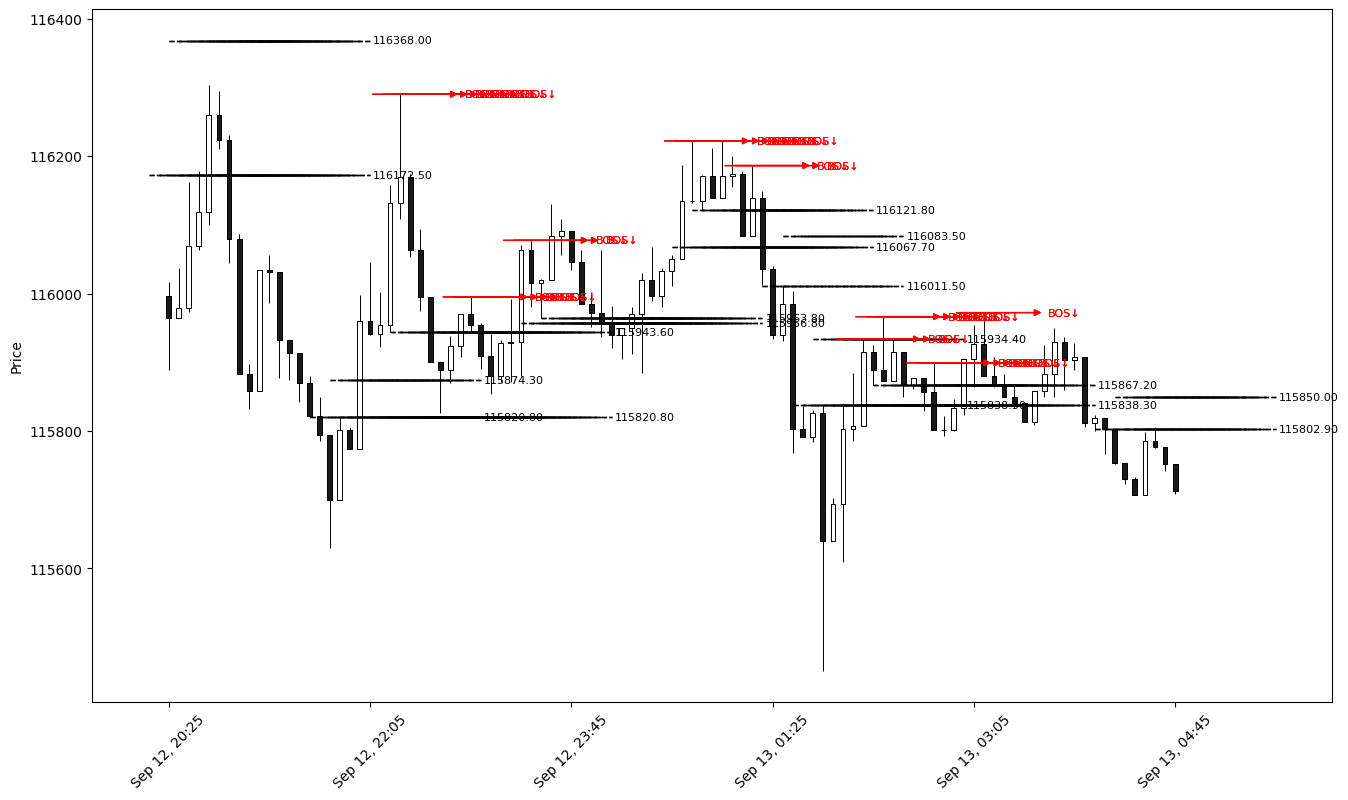

In [10]:
scanner = FractalFVGScanner(ohlc_m5, ohlc_m15)
matches = scanner.run_long()
print(matches[['direction', 'bos_time', 'high_fractal_time']].head())


df_plot = scanner.m5_df.copy().reset_index()
df_plot['fractal'] = scanner.m5_df['fractal'].fillna(0).astype(int)
df_plot['fractal_levels'] = scanner.m5_df['fractal_level']
df_plot['fvg'] = 0
df_plot['fvg_top'] = np.nan
df_plot['fvg_bottom'] = np.nan

mask = df_plot['active_fvg_id'].notna()
if mask.any():
    fvg_ids = df_plot.loc[mask, 'active_fvg_id'].astype(int)
    df_plot.loc[mask, 'fvg'] = fvg_ids.map(scanner.m15_fvg['direction'])
    df_plot.loc[mask, 'fvg_top'] = fvg_ids.map(scanner.m15_fvg['top'])
    df_plot.loc[mask, 'fvg_bottom'] = fvg_ids.map(scanner.m15_fvg['bottom'])

df_plot['bos'] = scanner.m5_df['bos'].fillna(0).astype(int)
df_plot['bos_level'] = df_plot['tracked_high']
df_plot['tracked_low'] = df_plot['tracked_low']
cols_defaults = [
    ('bos_fractal_index', np.nan),
    ('bos_fractal_index_local', np.nan),
    ('bos_fractal_time', pd.NaT),
    # якщо є інші обов’язкові стовпці – додавай тут
]
for col, default in cols_defaults:
    if col not in df_plot:
        df_plot[col] = default

plotting_chart_technicals(df_plot, 1050, 1150)
